In [12]:
import pickle
import numpy as np
import sklearn
import lightgbm as lgb
from s2aff.ror import RORIndex
from s2aff.text import fix_text
from s2aff.consts import PATHS
from s2aff.lightgbm_helpers import lightgbmExperiment
from s2aff.features import FEATURE_CONSTRAINTS, FEATURE_NAMES

FEATURE_NAMES = list(FEATURE_NAMES)

inds_to_check = [
    FEATURE_NAMES.index("names_frac_of_query_matched_in_text"),
    FEATURE_NAMES.index("acronyms_frac_of_query_matched_in_text"),
]

city_ind = FEATURE_NAMES.index("city_frac_of_query_matched_in_text")
stage_1_ind = FEATURE_NAMES.index("stage_1_score")


def eval_lgb(y, X, scores, group, weight=0.05):
    has_no_match = X[:, inds_to_check].sum(1) == 0
    scores_adjusted = scores - weight * has_no_match
    scores_adjusted = scores_adjusted + weight * X[:, city_ind]
    APs = []
    RR = []
    Pat1 = []
    scores_correct = []
    stage1_scores_correct = []
    deltas = []
    sorted_row_inds = np.sort(list(set(group)))
    for i in sorted_row_inds:
        flag = group == i
        p = scores_adjusted[flag]
        y_true = y[flag]
        x = X[flag, :]
        
        APs.append(sklearn.metrics.average_precision_score(y_true, p))
        argsort = np.argsort(p)[::-1]  # largest to smallest
        y_true_argsort = y_true[argsort]  # labels are sorted according to probs
        p = p[argsort]
        x = x[argsort, :]
        scores_correct.append(p[0])
        if len(p) > 1:
            deltas.append(p[0] - p[1])
        else:
            deltas.append(np.nan)
        stage1_scores_correct.append(x[0, stage_1_ind])
        try:
            first_index_of_label_1 = list(y_true_argsort).index(1) + 1  # where is the first appearance of label 1?
            RR.append(1.0 / first_index_of_label_1)  # reciprocal of that
            Pat1.append(first_index_of_label_1 == 1)  # is it the first position?
        except:
            RR.append(np.nan)
            Pat1.append(np.nan)

    results = {
        "MAP": np.mean(APs),
        "MRR": np.mean(RR),
        "Prec@1": np.mean(Pat1),
        "MAP_vec": APs,
        "MRR_vec": RR,
        "Prec@1_vec": Pat1,
        "group_vec": sorted_row_inds,
        "scores_correct_vec": scores_correct,
        "stage1_scores_correct_vec": stage1_scores_correct,
        "deltas": deltas
        
    }
    print({"MAP": np.mean(APs), "MRR": np.mean(RR), "Prec@1": np.mean(Pat1)})
    return results


In [5]:
with open(PATHS["lightgbm_gold_features"], "rb") as f:
    [
        (X_train, y_train, w_train, group_train, rors_train, qs_train),
        (X_val, y_val, w_val, group_val, rors_val, qs_val),
        (X_test, y_test, w_test, group_test, rors_test, qs_test),
    ] = pickle.load(f)

train_main_flag = np.array([i.endswith("[MAIN ONLY]") for i in qs_train])
train_main_address_flag = np.array([i.endswith("[MAIN+ADDRESS]") for i in qs_train])
train_augmented_flag = train_main_flag | train_main_address_flag

X_train = X_train[~train_augmented_flag]
y_train = y_train[~train_augmented_flag]
w_train = w_train[~train_augmented_flag]
group_train = group_train[~train_augmented_flag]
rors_train = rors_train[~train_augmented_flag]
qs_train = qs_train[~train_augmented_flag]


with open(PATHS["lightgbm_gold_no_ror_features"], "rb") as f:
    (X_none, y_none, w_none, group_none, rors_none, qs_none) = pickle.load(f)

# remove all rows with y_none == 1 because these would never be real candidates
remove_flag = y_none == 1
X_none = X_none[~remove_flag]
y_none = y_none[~remove_flag]
w_none = w_none[~remove_flag]
group_none = group_none[~remove_flag]
rors_none = rors_none[~remove_flag]
qs_none = qs_none[~remove_flag]

lgb_exp = lightgbmExperiment(
    learning_task="ranking",
    metric="rank_xendcg",
    eval_metric="map",
    n_estimators=500,
    hyperopt_evals=50,
    device="cpu",
    eval_at="1,5,25,100",
    tree_learner="data",
    random_seed=7,
    threads=64,
)

lgb_exp.constant_params["feature_pre_filter"] = False  # prevents some obscure errors
lgb_exp.bst = lgb.Booster(model_file=PATHS["lightgbm_model"])


In [ ]:
scores_train = lgb_exp.bst.predict(X_train)
scores_test = lgb_exp.bst.predict(X_test)
scores_val = lgb_exp.bst.predict(X_val)
scores_none = lgb_exp.bst.predict(X_none)

stage1_train = X_train[:, -3]
stage1_val = X_val[:, -3]
stage1_test = X_test[:, -3]
stage1_none = X_none[:, -3]

train_results = eval_lgb(y_train, X_train, lgb_exp.bst.predict(X_train), group_train)
val_results = eval_lgb(y_val, X_val, lgb_exp.bst.predict(X_val), group_val)
test_results = eval_lgb(y_test, X_test, lgb_exp.bst.predict(X_test), group_test)
none_results = eval_lgb(y_none, X_none, lgb_exp.bst.predict(X_none), group_none)

correct_train = np.array(train_results["Prec@1_vec"])
correct_val = np.array(val_results["Prec@1_vec"])
correct_test = np.array(test_results["Prec@1_vec"])
correct_none = np.array(none_results["Prec@1_vec"])

scores_correct_train = np.array(train_results["scores_correct_vec"])
scores_correct_val = np.array(val_results["scores_correct_vec"])
scores_correct_test = np.array(test_results["scores_correct_vec"])
scores_correct_none = np.array(none_results["scores_correct_vec"])

stage1_scores_train = np.array(train_results["stage1_scores_correct_vec"])
stage1_scores_val = np.array(val_results["stage1_scores_correct_vec"])
stage1_scores_test = np.array(test_results["stage1_scores_correct_vec"])
stage1_scores_none = np.array(none_results["stage1_scores_correct_vec"])

deltas_train = np.array(train_results["deltas"])
deltas_val = np.array(val_results["deltas"])
deltas_test = np.array(test_results["deltas"])
deltas_none = np.array(none_results["deltas"])


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(context='talk')

df = pd.DataFrame(
    {
        'lgb_scores': np.concatenate([scores_correct_train, scores_correct_val, scores_correct_test, scores_correct_none]),
        'stage1_scores': np.concatenate([stage1_scores_train, stage1_scores_val, stage1_scores_test, stage1_scores_none]),
        'correct': np.concatenate([correct_train, correct_val, correct_test, ['no_ror_at_all'] * len(correct_none)]),
        'deltas': np.concatenate([deltas_train, deltas_val, deltas_test, deltas_none]),
        'split': np.array(['train'] * len(correct_train) + ['val/test/no_ror'] * (len(correct_val) + len(correct_test) + len(correct_none))),        
    }
)

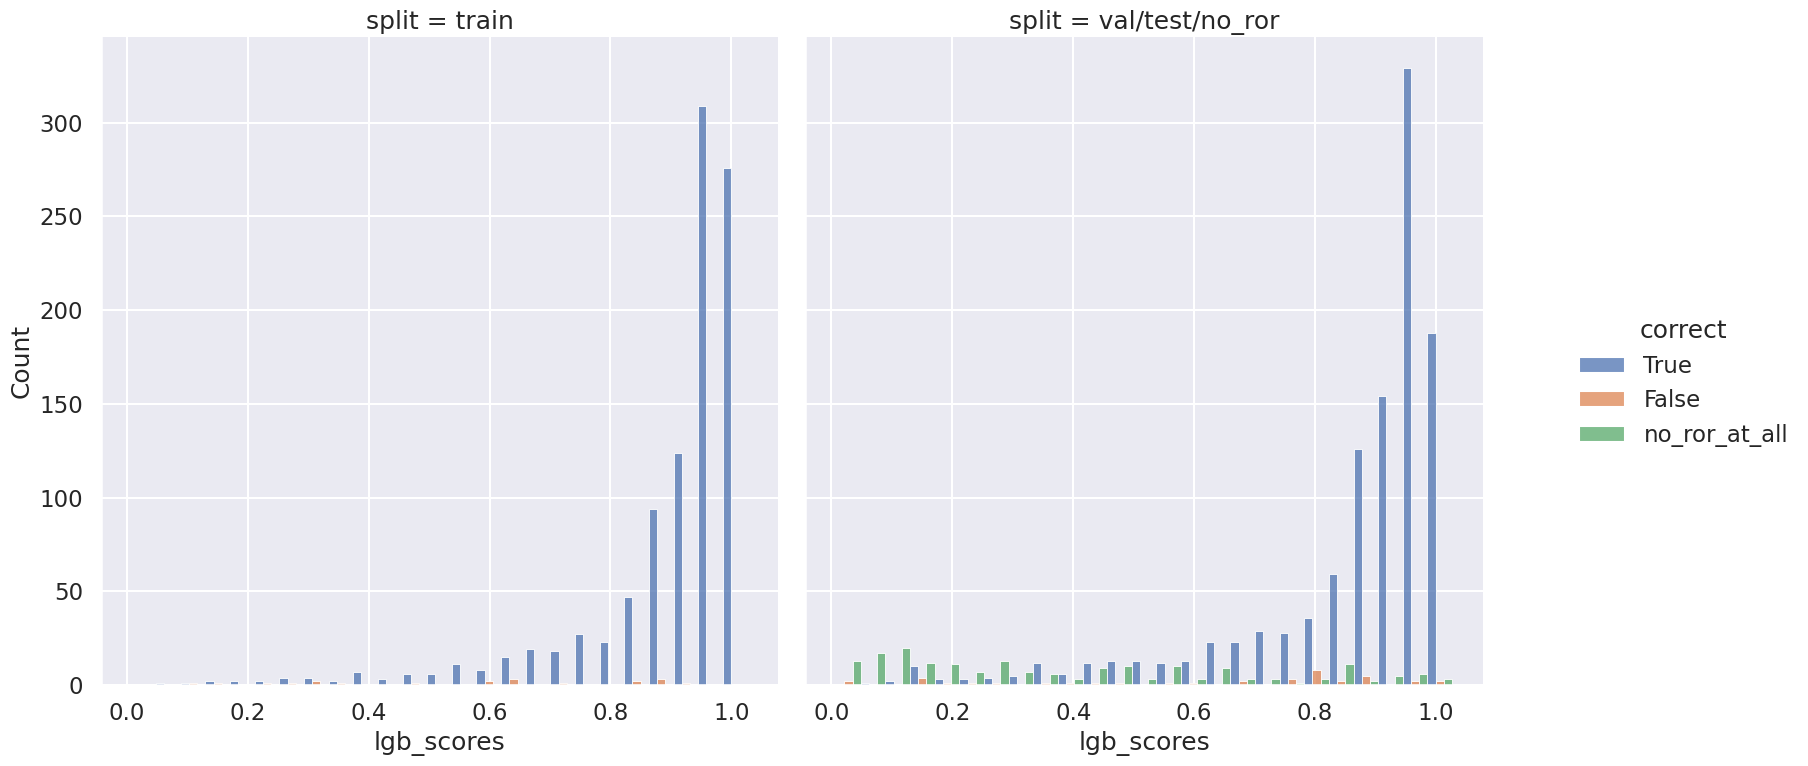

In [24]:
sns.displot(
    df, x="lgb_scores", hue="correct", col="split", multiple="dodge", height=8, facet_kws=dict(margin_titles=True), log_scale=(False, False), **dict(bins=25)
)

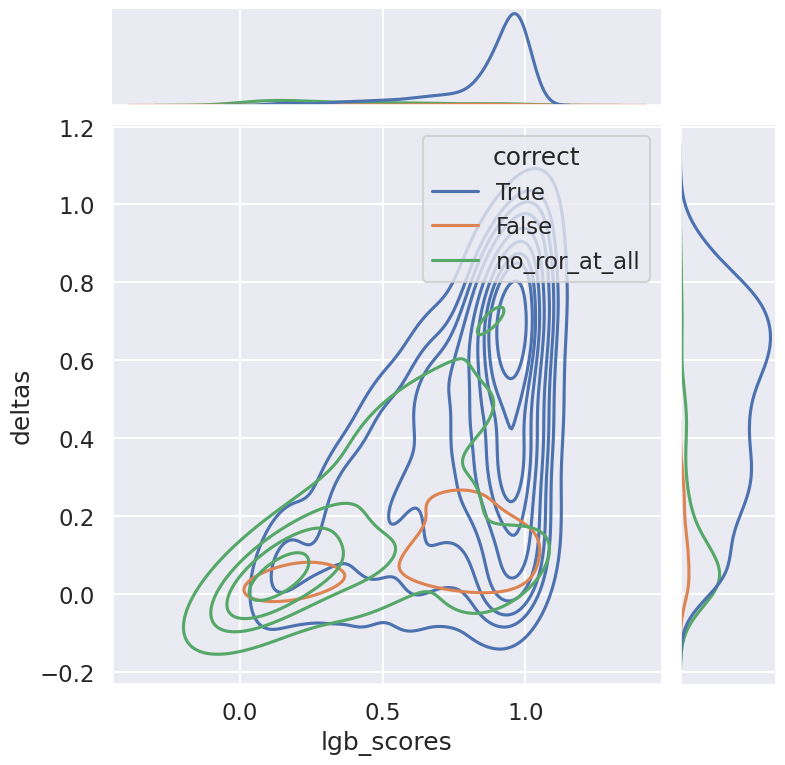

In [44]:
sns.jointplot(data=df[df.split == 'val/test/no_ror'], x="lgb_scores", y="deltas", hue="correct", kind='kde', height=8)

In [61]:
df.loc[:, 'throw_out'] = (df.lgb_scores < 0.3) & (df.deltas < 0.2)
df_not_train = df[df.split == 'val/test/no_ror'] 
df.groupby('correct')['throw_out'].value_counts()

correct        throw_out
False          False          46
               True           13
True           False        2080
               True           35
no_ror_at_all  False          97
               True           93
Name: throw_out, dtype: int64